In [1]:
import timm
import torch
import wandb
import fastai
import dill
import re
import random
import pathlib
import pickle
import PIL
import numpy as np
from fastai.vision.augment import cutout_gaussian
from fastai.callback.wandb import *
from fastai.vision.all import *
from fastai.vision.core import *
from fastai.text.core import RegexLabeller
from fastai.vision.utils import get_image_files
from fastai.data.block import DataBlock
from fastai.data.core import *
from fastai.tabular.all import *
from fastcore.foundation import L
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from huggingface_hub import notebook_login, push_to_hub_fastai, from_pretrained_fastai
from torchvision.transforms import GaussianBlur
from pathlib import Path
# os.environ['WANDB_WATCH'] = 'false'
os.environ['WANDB_NOTEBOOK_NAME'] = 'Train.ipynb'

In [2]:
folds = 1
data_length = 20


# config = SimpleNamespace(
#     batch_size=64,  #16, #256,
#     epochs=5,
#     lr=3e-3,
#     img_size=224, # 224, 256 for small model on huggingface
#     seed=42,
#     pretrained=True,
#     top_k_losses=5,
#     model_name="maxvit_rmlp_base_rw_224.sw_in12k_ft_in1k",# "maxvit_rmlp_base_rw_224.sw_in12k_ft_in1k",# maxvit_nano_rw_256.sw_in1k for HF spaces
#     wandb_project="Beetle_classifier", 
#     wandb_group="ambrosia_symbiosis",
#     job_type="training_cv_5fold_size"
#     )

config = SimpleNamespace(
    batch_size=64,  #16, #256,
    epochs=1,
    lr=3e-3,
    img_size=224, # 224, 256 for small model on huggingface
    seed=42,
    pretrained=True,
    top_k_losses=5,
    model_name="maxvit_rmlp_base_rw_224.sw_in12k_ft_in1k",# "maxvit_rmlp_base_rw_224.sw_in12k_ft_in1k",# maxvit_nano_rw_256.sw_in1k for HF spaces
    wandb_project="Beetle_classifier", 
    wandb_group="ambrosia_symbiosis",
    job_type="training_cv_5fold_size"
    )

species_lst = ['Coccotypes_dactyliperda', 'Hylesinus_varius', 'Monarthrum_fasciatum',
                'Phloeosinus_dentatus', 'Pityophthorus_juglandis', 'Platypus_cylindrus',
                'Pycnarthrum_hispidium', 'Scolotodes_schwarzi', 'Xyleborinus_saxesenii',
                'Xyleborus_affinis', 'Xylosandrus_compactus',
                'Xylosandrus_crassiusculus']

species='Coccotypes_dactyliperda'

In [3]:
def get_all_paths_in_folder(folder_path):
    folder_path = Path(folder_path)
    paths = []
    for path in folder_path.glob('**/*'):
        if path.is_file():
            paths.append(pathlib.PosixPath(path))
    return paths

def get_vials_lst(train_path):
    paths_lst = get_all_paths_in_folder(train_path)
    files_temp = [f for f in paths_lst if (species in str(f))]
    vial_subset_lst = list(set([re.search(r'.*_([^_]+_.*[^_]+)_.*_.*', str(path)).group(1) for path in files_temp]))
    vial_subset_lst = sorted(vial_subset_lst)
    random.seed(config.seed)
    random.shuffle(vial_subset_lst)
    return vial_subset_lst

def filter_paths_lst(file, seed, vial_subset_lst, species, data_len):
    if data_len:
        vial_lst = vial_subset_lst[:data_len]
        if (species not in str(file)):
            return True
        elif (species in str(file)) and any((vial_sub+"_") in str(file) for vial_sub in vial_lst):
            return True
        elif (species in str(file)) and any((vial_sub+"_") not in str(file) for vial_sub in vial_lst):
            return False
        else:
            return False
    else:
        return True

def get_image_files_with_string(path, species, subfolders, vial_subset_lst, data_len):
    return get_image_files(path, recurse=True, folders=subfolders).filter(partial(filter_paths_lst, seed=config.seed, species=species, vial_subset_lst=vial_subset_lst, data_len=data_len))

# Define a custom transform for Gaussian blur
def gaussian_blur(x, p=0.5, kernel_size_min=3, kernel_size_max=20, sigma_min=0.1, sigma_max=3):
    if x.ndim == 4:
        for i in range(x.shape[0]):
            if random.random() < p:
                kernel_size = random.randrange(kernel_size_min, kernel_size_max + 1, 2)
                sigma = random.uniform(sigma_min, sigma_max)
                x[i] = GaussianBlur(kernel_size=kernel_size, sigma=sigma)(x[i])
    return x

def get_images(dataset_path, batch_size, data_len, species, img_size, seed, subfolders=('train','valid')):
    "The beetles dataset"
    vial_subset_lst = get_vials_lst(str(Path(dataset_path, subfolders[0])))
    # files = get_image_files(path=dataset_path, recurse=True, folders=subfolders)
    transforms = aug_transforms(    # transformatiosn that are only applied ot training and not inference
                           batch=False,
                           pad_mode='zeros',
                           size=img_size,
                           p_affine=0.8,
                           p_lighting=0.8,
                           max_rotate=360.0,
                           mult=1.0, 
                           do_flip=True, 
                           flip_vert=False,
                           min_zoom=1.0,
                           max_zoom=1.1, 
                           max_lighting=0.75,
                           max_warp=0.2, 
                           mode='bilinear', 
                           align_corners=True,
                           min_scale=1.0,
                           xtra_tfms=[RandomErasing(p=0.8, max_count=5, sh=0.25)]) # this adds random erasing to entire batches
    transforms.append(partial(gaussian_blur, p=0.8))
    transforms.append(Normalize.from_stats(*imagenet_stats))
    dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                       # get_items = partial(get_image_files,
                       #                     recurse=True,
                       #                    folders=subfolders),
                       get_items = partial(get_image_files_with_string,
                                           subfolders=subfolders,
                                           species=species,
                                           data_len=data_len, 
                                           vial_subset_lst=vial_subset_lst
                                           ),
                       splitter = GrandparentSplitter(train_name=subfolders[0], valid_name=subfolders[1]),
                       get_y = parent_label,
                       item_tfms = Resize(img_size, ResizeMethod.Pad, pad_mode='zeros'), # resize trasnformation is applied during inference too                                    
                       batch_tfms = transforms)
    dls = dblock.dataloaders(dataset_path, bs = batch_size, num_workers=4)
    print(species, " > Image Count: ", len([f for f in dls.train_ds.items if species in str(f)]))
    return dls

def train(config, dataset_path, species, subfolders=('train','valid'), data_len=None):
    "Train the model using the supplied config"
    dls = get_images(dataset_path=dataset_path, 
                     batch_size=config.batch_size, 
                     img_size=config.img_size, 
                     seed=config.seed, 
                     subfolders=subfolders, 
                     data_len=data_len, 
                     species=species)
    
    labels = np.array([re.split(r'/|\\', str(x))[-2] for x in dls.items])
    classes = np.unique(labels)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=labels)
    class_weights = {c: w for c, w in zip(classes, weights)}
    weights = tensor([class_weights[c] for c in dls.vocab]).to(dls.device)
    # wandb.init(project=config.wandb_project, group=config.wandb_group, job_type=config.job_type, config=config) # it is a good idea to keep these functions out of the training function due to some exporting issues
    cbs = [MixedPrecision(), ShowGraphCallback(), SaveModelCallback(), WandbCallback(log='gradients')] # (all, parameters, gradients or None) parameters and all does nto work currently wandb needs to be updated
    learn = vision_learner(dls, 
                           config.model_name, 
                           loss_func=LabelSmoothingCrossEntropy(weight=weights), # this fucntion is used for class imbalance it is a regularization technique # LabelSmoothingCrossEntropyFlat is used for multi dimensional data
                           metrics=[error_rate, 
                                    accuracy, 
                                    top_k_accuracy], 
                           cbs=cbs, 
                           pretrained=config.pretrained)
    learn.fine_tune(config.epochs, base_lr=config.lr)
    interp = ClassificationInterpretation.from_learner(learn)
    interp.plot_confusion_matrix()
    interp.plot_top_losses(config.top_k_losses, nrows=config.top_k_losses)
    # wandb.finish() # it is a good idea to keep these functions out of the training function due to some exporting issues
    return learn


In [4]:
# save the number of images used in each 
results_df = pd.DataFrame()
dataset_path = r"/blue/hulcr/gmarais/Beetle_data/kfold_images/train_data"
for i in range(1,folds+1):
    img_num_lst = []
    for data_len in range(1, data_length):
        dls = get_images(dataset_path=dataset_path, 
                     batch_size=config.batch_size, 
                     img_size=config.img_size, 
                     seed=config.seed, 
                     subfolders=('train_'+str(i),'valid_'+str(i)), 
                     data_len=data_len, 
                     species=species)
        img_num_lst.append(len([f for f in dls.train_ds.items if species in str(f)]))
    results_df["fold-"+str(i)+"_image_number"] = img_num_lst
results_df.to_csv("small_train_data_size_df.csv", index=False)

Coccotypes_dactyliperda  > Image Count:  207
Coccotypes_dactyliperda  > Image Count:  423
Coccotypes_dactyliperda  > Image Count:  644
Coccotypes_dactyliperda  > Image Count:  816
Coccotypes_dactyliperda  > Image Count:  990
Coccotypes_dactyliperda  > Image Count:  1172
Coccotypes_dactyliperda  > Image Count:  1356
Coccotypes_dactyliperda  > Image Count:  1517
Coccotypes_dactyliperda  > Image Count:  1693
Coccotypes_dactyliperda  > Image Count:  1865
Coccotypes_dactyliperda  > Image Count:  2004
Coccotypes_dactyliperda  > Image Count:  2179
Coccotypes_dactyliperda  > Image Count:  2379
Coccotypes_dactyliperda  > Image Count:  2534
Coccotypes_dactyliperda  > Image Count:  2735
Coccotypes_dactyliperda  > Image Count:  2945
Coccotypes_dactyliperda  > Image Count:  3101
Coccotypes_dactyliperda  > Image Count:  3280
Coccotypes_dactyliperda  > Image Count:  3280


,fold-1_image_number
0,207
1,423
2,644
3,816
4,990
5,1172
6,1356
7,1517
8,1693
9,1865


Training:  1
Data length:  1 207
Not tested


wandb: Currently logged in as: christopher-marais. Use `wandb login --relogin` to force relogin


Coccotypes_dactyliperda  > Image Count:  207


/blue/hulcr/gmarais/conda/envs/BC_310/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484808560/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.432079,0.948720,0.129978,0.870022,0.996655,03:55


Better model found at epoch 0 with valid_loss value: 0.9487197995185852.


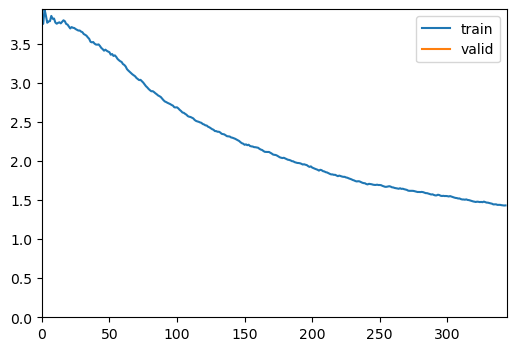

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.763169,0.647674,0.007009,0.992991,1.000000,04:02


Better model found at epoch 0 with valid_loss value: 0.6476736664772034.


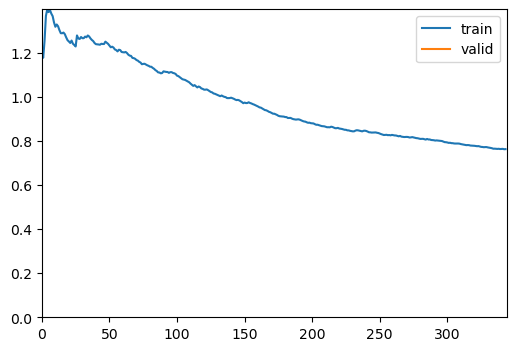

accuracy,▁█
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
error_rate,█▁
lr_0,▁▁▁▂▂▂▃▃▄▄▅▅▆▆▇▇▇███▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▁▁▂▂▂▃▃▄▄▅▅▆▆▇▇▇███▂▂▃▄▄▄▄▄▄▄▄▃▃▃▂▂▁▁▁▁
mom_0,████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁█▇▆▃▂▁▁▁▂▂▃▃▄▅▆▇▇███
mom_1,████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁█▇▆▃▂▁▁▁▂▂▃▃▄▅▆▇▇███
raw_loss,█▇▅▅▅▄▄▄▃▄▃▃▃▃▃▂▃▂▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Testing:  1


Training:  1
Data length:  2 423
Not tested


Coccotypes_dactyliperda  > Image Count:  423


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.390693,0.867164,0.091908,0.908092,0.997451,03:19


Better model found at epoch 0 with valid_loss value: 0.8671637177467346.


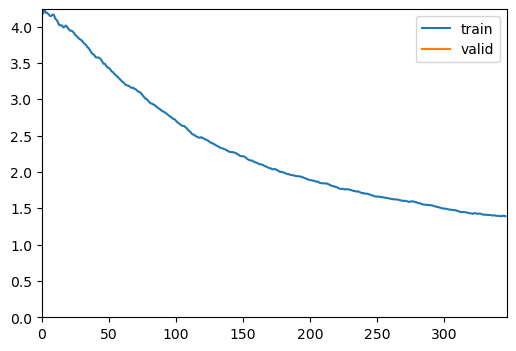

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.746683,0.630597,0.005894,0.994106,0.999841,04:02


Better model found at epoch 0 with valid_loss value: 0.6305974721908569.


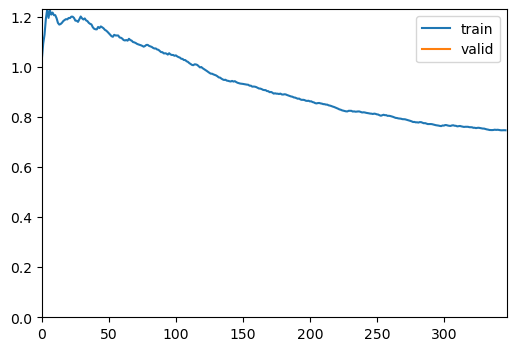

accuracy,▁█
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
error_rate,█▁
lr_0,▁▁▁▂▂▂▃▃▄▄▅▅▆▆▇▇▇███▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▁▁▂▂▂▃▃▄▄▅▅▆▆▇▇▇███▂▂▂▃▄▄▄▄▄▄▄▃▃▃▂▂▂▁▁▁
mom_0,████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁█▇▆▄▂▁▁▁▂▂▃▃▄▅▆▆▇▇██
mom_1,████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁█▇▆▄▂▁▁▁▂▂▃▃▄▅▆▆▇▇██
raw_loss,█▇▆▅▅▄▃▄▄▃▃▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Testing:  1


Training:  1
Data length:  3 644
Not tested


Coccotypes_dactyliperda  > Image Count:  644


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


In [ ]:
# Training small dataset
for i in range(1,folds+1):
    for data_len in range(1, data_length):
        print("Training: ", str(i))
        print("Data length: ", str(data_len), results_df["fold-"+str(i)+"_image_number"][data_len-1])
        if not os.path.isfile(str(data_len)+"_Testing_prediction_probabilities_fold-"+str(i)+".csv"):
            print("Not tested")
            # Train Model
            dataset_path = r"/blue/hulcr/gmarais/Beetle_data/kfold_images/train_data"
            # dataset_path = r"F:\Beetle_data\kfold_images\train_data"
            wandb.init(project=config.wandb_project, group=config.wandb_group, job_type=config.job_type, config=config)
            learn = train(config=config,
                          species=species,
                          dataset_path=dataset_path, 
                          subfolders=('train_'+str(i),'valid_'+str(i)),
                          data_len=data_len)
            wandb.finish()

            # get predicstions and labels
            print("Testing: ", str(i))
            learn.remove_cb(WandbCallback)
            # Get validation labels and predictions
            files = get_image_files(path=dataset_path, recurse=True, folders=('valid_'+str(i))) 
            test_dl = learn.dls.test_dl(files, with_labels=True) # load data as a dataloader
            preds, targets = learn.get_preds(dl=test_dl)
            pred_df = pd.DataFrame(preds.cpu().numpy(), columns=learn.dls.vocab)
            pred_df.to_csv(str(data_len)+"_Validation_prediction_probabilities_fold-"+str(i)+".csv")

            # testing data
            test_dataset_path = r"/blue/hulcr/gmarais/Beetle_data/kfold_images"
            files = get_image_files(path=test_dataset_path, recurse=True, folders=('test_data'))
            test_dl = learn.dls.test_dl(files, with_labels=True) # load data as a dataloader
            preds, targets = learn.get_preds(dl=test_dl)
            pred_df = pd.DataFrame(preds.cpu().numpy(), columns=learn.dls.vocab)
            pred_df.to_csv(str(data_len)+"_Testing_prediction_probabilities_fold-"+str(i)+".csv")
        else:
            print("Already tested")
print("------------FINISHED----------")